阅读理解即给出一篇文档让机器阅读, 在机器读完后问机器一个关于这份文档的问题.让机器来作答.
当然这个问题的答案一定要出现在这个文档中.思考如何实现.

### squad原数据格式

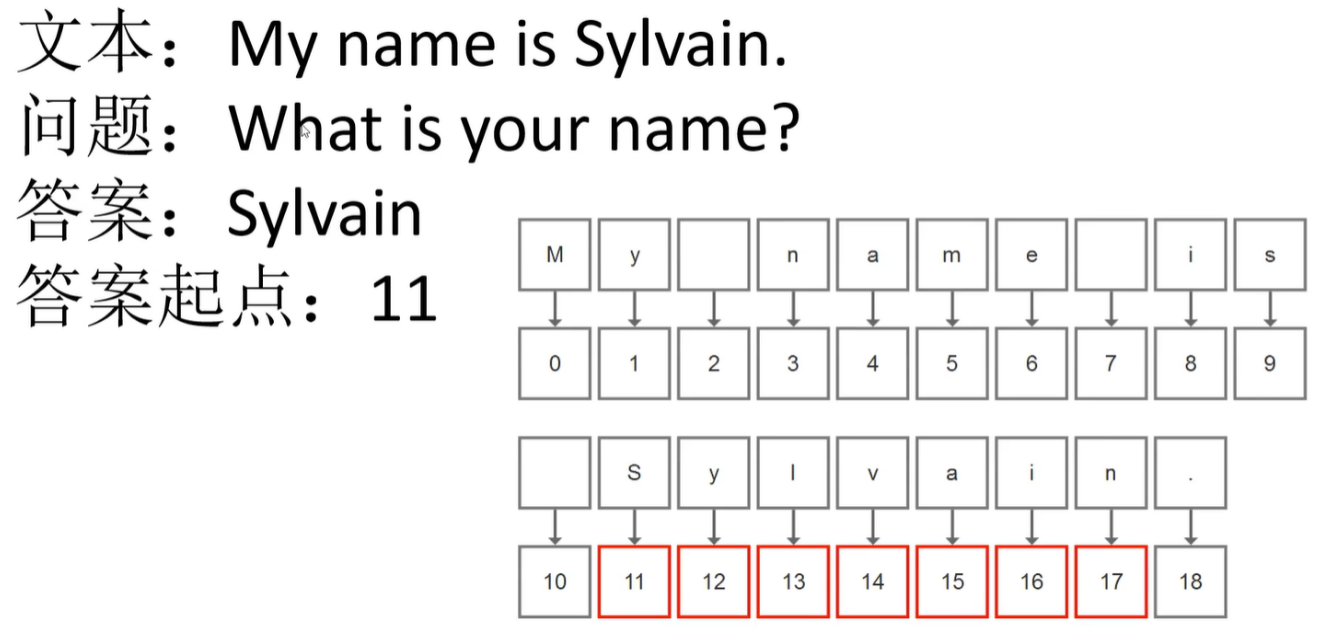

### 编码之后的格式

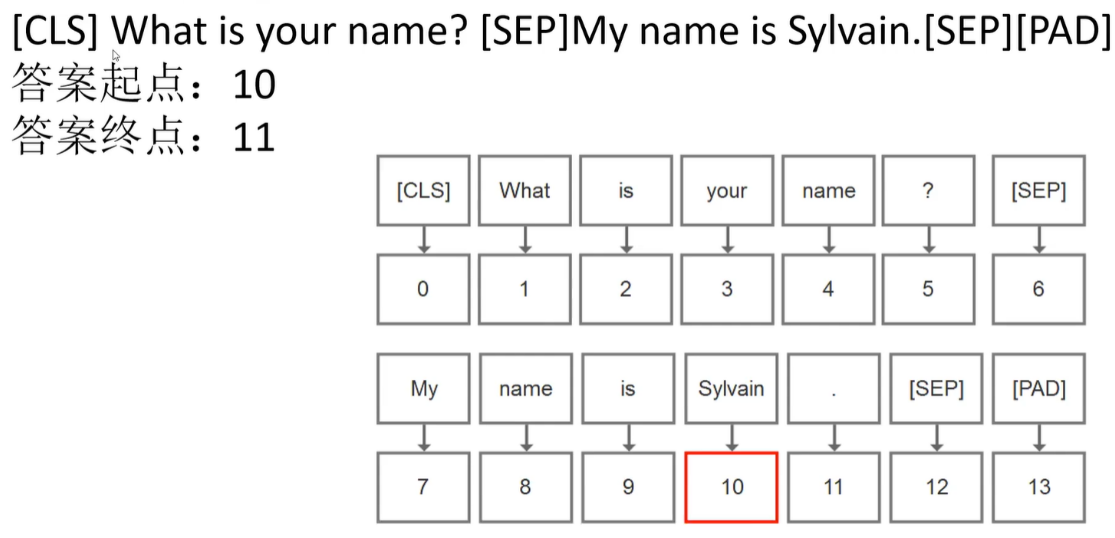

如何完成这个功能, 借助huggingface官方提供的工具函数, 我们把它当成黑盒函数来使用

In [1]:
from transformers import AutoTokenizer

In [2]:
# 加载分词工具
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
print(tokenizer)
tokenizer('What is your name?', 'My name is Sylvain.')

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


{'input_ids': [101, 2054, 2003, 2115, 2171, 1029, 102, 2026, 2171, 2003, 25353, 22144, 2378, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [3]:
from datasets import load_dataset

# 加载数据集
dataset = load_dataset('squad')
dataset

Found cached dataset squad (C:/Users/SupercoldZzz/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [4]:
dataset['train'][0]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

In [5]:
# 对数据进行采样.
dataset['train'] = dataset['train'].shuffle().select(range(10000))
dataset['validation'] = dataset['validation'].shuffle().select(range(200))

In [6]:
def prepare_train_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples['question'],
        examples['context'],
        truncation='only_second',
        max_length=384,
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding='max_length',
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char
                    and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[
                        token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(
                    token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [7]:
examples = prepare_train_features(dataset['train'][:10])
print(examples)

{'input_ids': [[101, 2054, 2828, 1997, 5069, 2001, 14071, 2033, 2063, 1029, 102, 2004, 14165, 2211, 2000, 2709, 1999, 1996, 3865, 1010, 1996, 2103, 2001, 9860, 2011, 1996, 22894, 2033, 2063, 9288, 1999, 3172, 1010, 2043, 2410, 2111, 2020, 2730, 1999, 2019, 6206, 12219, 2252, 1999, 1996, 2248, 2212, 1010, 5862, 1005, 1055, 22321, 1012, 2927, 2007, 7513, 1005, 1055, 3245, 2693, 2013, 19334, 1010, 2047, 3290, 2000, 3518, 26756, 1010, 2899, 1010, 5862, 1998, 2049, 9435, 2150, 2188, 2000, 1037, 2193, 1997, 2974, 3316, 2164, 9733, 1012, 4012, 1010, 2613, 7159, 9316, 1010, 10022, 1997, 2637, 1010, 23680, 10376, 12562, 1006, 2085, 2112, 1997, 2012, 1004, 1056, 12969, 1007, 1010, 5755, 25379, 1006, 2085, 1056, 1011, 4684, 1007, 1010, 1998, 20906, 11578, 2107, 2004, 8072, 25379, 1006, 2101, 4156, 2011, 19087, 1007, 1010, 2540, 6786, 1006, 2101, 4156, 2011, 3731, 4045, 1007, 1010, 6887, 7274, 3695, 1011, 2491, 1006, 2101, 4156, 2011, 19960, 15312, 2594, 1007, 1010, 1062, 24335, 23924, 16530, 2015

In [8]:
tokenizer.decode(examples['input_ids'][2][144:144])

''

In [9]:
# 还原成文字来查看
for i in range(len(examples['input_ids'])):
    input_ids = examples['input_ids'][i]
    start_positions = examples['start_positions'][i]
    end_positions = examples['end_positions'][i]
    
    print('问题和文本')
    question_and_context = tokenizer.decode(input_ids)
    print(question_and_context)
    
    print('答案')
    answer = tokenizer.decode(input_ids[start_positions:end_positions])
    print('start_positions: ', start_positions)
    print('end_positions: ', end_positions)
    print(answer)
    
    print('原答案')
    original_answer = dataset['train'][i]['answers']['text'][0]
    print(original_answer)
    print()

问题和文本
[CLS] what type of establishment was wan mee? [SEP] as prosperity began to return in the 1980s, the city was stunned by the wah mee massacre in 1983, when 13 people were killed in an illegal gambling club in the international district, seattle's chinatown. beginning with microsoft's 1979 move from albuquerque, new mexico to nearby bellevue, washington, seattle and its suburbs became home to a number of technology companies including amazon. com, realnetworks, nintendo of america, mccaw cellular ( now part of at & t mobility ), voicestream ( now t - mobile ), and biomedical corporations such as heartstream ( later purchased by philips ), heart technologies ( later purchased by boston scientific ), physio - control ( later purchased by medtronic ), zymogenetics, icos ( later purchased by eli lilly and company ) and immunex ( later purchased by amgen ). this success brought an influx of new residents with a population increase within city limits of almost 50, 000 between 1990 and 20

In [10]:
dataset = dataset.map(
    function=prepare_train_features,
    batched=True,
    remove_columns=['id', 'title', 'context', 'question', 'answers']
)

print(dataset['train'][0])

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

{'input_ids': [101, 2054, 2828, 1997, 5069, 2001, 14071, 2033, 2063, 1029, 102, 2004, 14165, 2211, 2000, 2709, 1999, 1996, 3865, 1010, 1996, 2103, 2001, 9860, 2011, 1996, 22894, 2033, 2063, 9288, 1999, 3172, 1010, 2043, 2410, 2111, 2020, 2730, 1999, 2019, 6206, 12219, 2252, 1999, 1996, 2248, 2212, 1010, 5862, 1005, 1055, 22321, 1012, 2927, 2007, 7513, 1005, 1055, 3245, 2693, 2013, 19334, 1010, 2047, 3290, 2000, 3518, 26756, 1010, 2899, 1010, 5862, 1998, 2049, 9435, 2150, 2188, 2000, 1037, 2193, 1997, 2974, 3316, 2164, 9733, 1012, 4012, 1010, 2613, 7159, 9316, 1010, 10022, 1997, 2637, 1010, 23680, 10376, 12562, 1006, 2085, 2112, 1997, 2012, 1004, 1056, 12969, 1007, 1010, 5755, 25379, 1006, 2085, 1056, 1011, 4684, 1007, 1010, 1998, 20906, 11578, 2107, 2004, 8072, 25379, 1006, 2101, 4156, 2011, 19087, 1007, 1010, 2540, 6786, 1006, 2101, 4156, 2011, 3731, 4045, 1007, 1010, 6887, 7274, 3695, 1011, 2491, 1006, 2101, 4156, 2011, 19960, 15312, 2594, 1007, 1010, 1062, 24335, 23924, 16530, 2015,

In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 10113
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 202
    })
})

In [12]:
import torch
from transformers.data.data_collator import default_data_collator

In [13]:
# 数据加载器
loader = torch.utils.data.DataLoader(
    dataset = dataset['train'],
    batch_size=16,
    collate_fn=default_data_collator,
    shuffle=True,
    drop_last=True
)

for data in loader:
    break
    
len(loader), data

(632,
 {'input_ids': tensor([[  101,  2073,  2003,  ...,     0,     0,     0],
          [  101, 25479,  3605,  ...,     0,     0,     0],
          [  101,  2054,  3609,  ...,     0,     0,     0],
          ...,
          [  101,  2054,  2001,  ...,     0,     0,     0],
          [  101,  2043,  2001,  ...,     0,     0,     0],
          [  101,  2247,  2007,  ...,     0,     0,     0]]),
  'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          ...,
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0]]),
  'start_positions': tensor([ 22,  46, 137,  86,  13, 178,  47,  11,  88,  55,  56,  70,  88,  79,
           31,  19]),
  'end_positions': tensor([ 35,  46, 137,  92,  16, 180,  56,  14,  91,  60,  56,  72, 109,  83,
           31,  19])})

In [14]:
# 定义下游任务的模型
from transformers import AutoModelForQuestionAnswering, DistilBertModel

In [15]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrained = DistilBertModel.from_pretrained('distilbert-base-uncased')
        
        self.fc = torch.nn.Sequential(
            torch.nn.Dropout(0.1),
            torch.nn.Linear(768, 2)
        )
        
        # 加载预训练模型权重.
        parameters = AutoModelForQuestionAnswering.from_pretrained('distilbert-base-uncased')
        self.fc[1].load_state_dict(parameters.qa_outputs.state_dict())
        
    def forward(self, input_ids, attention_mask, start_positions, end_positions):
        # [b, lens] -> embedding -> [b, lens, embed_size] -> pretrained -> [b, lens, 768]
        logits = self.pretrained(input_ids=input_ids, attention_mask=attention_mask)
        logits = logits.last_hidden_state
        # [b, lens, 768] -> [b, lens, 2]
        logits = self.fc(logits)
        # [b, lens, 2] -> [b, lens, 1], [b, lens, 1]
        start_logits, end_logits = logits.split(1, dim=2)
        # [b, lens, 1] -> [b, lens]
        start_logits = start_logits.squeeze(2)
        end_logits = end_logits.squeeze(2)
        
        # 起点和终点都不能超出句子的长度
        lens = start_logits.shape[1]
        start_positions = start_positions.clamp(0, lens)
        end_positions = end_positions.clamp(0, lens)
        
        criterion = torch.nn.CrossEntropyLoss(ignore_index=lens)
        
        start_loss = criterion(start_logits, start_positions)
        end_loss = criterion(end_logits, end_positions)
        # 求平均损失
        loss = (start_loss + end_loss) / 2
        
        return {'loss': loss, 'start_logits': start_logits, 'end_logits': end_logits}

In [16]:
model = Model()
out = model(**data)
out['loss'], out['start_logits'].shape, out['end_logits'].shape

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_proje

(tensor(5.9629, grad_fn=<DivBackward0>),
 torch.Size([16, 384]),
 torch.Size([16, 384]))

In [17]:
out['start_logits']

tensor([[ 0.0228,  0.1262,  0.1578,  ...,  0.1435,  0.0201,  0.2220],
        [ 0.2419, -0.1595,  0.1950,  ...,  0.0106,  0.1423,  0.1011],
        [ 0.1407,  0.2449,  0.4859,  ...,  0.1164,  0.1793,  0.2311],
        ...,
        [ 0.0916,  0.3904,  0.4410,  ...,  0.0520,  0.1593,  0.1145],
        [-0.0409, -0.0676,  0.0823,  ...,  0.0825,  0.1228,  0.0065],
        [ 0.1237,  0.0285,  0.0831,  ...,  0.0390,  0.1089, -0.0170]],
       grad_fn=<SqueezeBackward1>)

In [18]:
# 测试
def test(model):
    model.eval()
    
    loader_val = torch.utils.data.DataLoader(
        dataset=dataset['validation'],
        batch_size=32,
        collate_fn=default_data_collator,
        shuffle=True,
        drop_last=True
    )
    
    start_offset = 0
    end_offset = 0
    
    total = 0
    
    for i, data in enumerate(loader_val):
        # 计算
        with torch.no_grad():
            out = model(**data)
            
        start_offset += (out['start_logits'].argmax(dim=1) - data['start_positions']).abs().sum().item()
        end_offset += (out['end_logits'].argmax(dim=1) - data['end_positions']).abs().sum().item()
        
        total += 32
        
        if i % 10 == 0:
            print(i)
            
        if i == 50:
            break
            
    print(start_offset / total, end_offset / total)
    
    start_logits = out['start_logits'].argmax(dim=1)
    end_logits = out['end_logits'].argmax(dim=1)
    for i in range(4):
        input_ids = data['input_ids'][i]
        pred_answer = input_ids[start_logits[i]: end_logits[i]]
        label_answer = input_ids[data['start_positions'][i] : data['end_positions'][i]]
        
        print('input_ids=', tokenizer.decode(input_ids))
        print('pred_answer=', tokenizer.decode(pred_answer))
        print('label_answer=', tokenizer.decode(label_answer))
        print()

In [19]:
# test(model)

In [20]:
from transformers import AdamW
from transformers.optimization import get_scheduler

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [22]:
def train():
    optimizer = AdamW(model.parameters(), lr=2e-5)
    scheduler = get_scheduler(name='linear',
                             num_warmup_steps=0,
                             num_training_steps=len(loader),
                             optimizer=optimizer)
    model.to(device)
    model.train()
    
    for i, data in enumerate(loader):
        input_ids, attention_mask = data['input_ids'], data['attention_mask']
        start_positions, end_positions = data['start_positions'], data['end_positions']
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        start_positions = start_positions.to(device)
        end_positions = end_positions.to(device)
        
        out = model(input_ids=input_ids, 
                    attention_mask=attention_mask, 
                    start_positions=start_positions, 
                    end_positions=end_positions)
        loss = out['loss']
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        optimizer.zero_grad()
        model.zero_grad()
        
        if i % 50 == 0:
            lr = optimizer.state_dict()['param_groups'][0]['lr']
            
            start_offset = (out['start_logits'].argmax(dim=1) - start_positions).abs().sum().item() / 16
            end_offset = (out['end_logits'].argmax(dim=1) - end_positions).abs().sum().item() / 16
            
            print(i, loss.item(), lr, start_offset, end_offset)

In [23]:
train()

D:\.venv\lib\site-packages\transformers\optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


0 5.906922340393066 1.996835443037975e-05 79.5625 83.6875
50 4.296964645385742 1.838607594936709e-05 51.1875 42.625
100 4.092566013336182 1.6803797468354432e-05 46.3125 41.875
150 3.7639427185058594 1.5221518987341772e-05 42.3125 61.0625
200 3.1152219772338867 1.3639240506329114e-05 26.875 42.4375
250 2.6302919387817383 1.2056962025316457e-05 57.375 36.125
300 2.719733238220215 1.0474683544303799e-05 14.6875 18.875
350 2.4825479984283447 8.892405063291139e-06 16.5 18.5625
400 1.812427282333374 7.310126582278481e-06 6.8125 7.5
450 2.2499594688415527 5.727848101265824e-06 15.25 5.0
500 2.6189513206481934 4.145569620253165e-06 19.0 23.3125
550 2.367091178894043 2.5632911392405064e-06 13.4375 17.875
600 2.4237546920776367 9.810126582278482e-07 20.9375 29.5625


In [24]:
torch.save(model, '../data/阅读理解.model')

In [27]:
model2 = torch.load('../data/阅读理解.model', map_location='cpu')

In [28]:
test(model2)

0
13.229166666666666 11.234375
input_ids= [CLS] what nobel memorial prize in economic sciences winner is also a university alumni member? [SEP] in economics, notable nobel memorial prize in economic sciences winners milton friedman, a major advisor to republican u. s. president ronald reagan and conservative british prime minister margaret thatcher, george stigler, nobel laureate and proponent of regulatory capture theory, gary becker, an important contributor to the family economics branch of economics, herbert a. simon, responsible for the modern interpretation of the concept of organizational decision - making, paul samuelson, the first american to win the nobel memorial prize in economic sciences, and eugene fama, known for his work on portfolio theory, asset pricing and stock market behaviour, are all graduates. american economist, social theorist, political philosopher, and author thomas sowell is also an alumnus. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 